## Part 1&mdash;Constructing a station pairs dataset

In [1]:
from zipfile import ZipFile
z = ZipFile("/Users/alex/Downloads/201811-fordgobike-tripdata.csv.zip")

In [2]:
z.extractall("./data/input/")

In [3]:
%ls ./data/input

201811-fordgobike-tripdata.csv


In [307]:
# classify stations by city
from sklearn.cluster import KMeans
station_coords = (df[['end_station_latitude', 'end_station_longitude']]
                  .apply(lambda v: tuple(v), axis='columns')
                  .unique())
X = np.stack([[p[0] for p in station_coords], [p[1] for p in station_coords]], axis=1)
clf = KMeans(n_clusters=3)
clf.fit(X)
del station_coords
del X


# routine for finding trip inverses in the dataset
# slow, as it doesn't use an index, but adequate
def find_reverse_route_srs(df, route_srs):
    """
    Given a route extracted from the dataframe as input finds its inverse.
    Including how many times it occurred in the dataset.
    If the inverse never occurred None will be returned.
    """
    ss_id, es_id = [route_srs['start_station_id'], route_srs['end_station_id']]
    results = df.query(f"start_station_id == {es_id} & end_station_id == {ss_id}")
    if len(results) == 1:
        return results.index[0]
    else:
        return np.nan

    
# routine for adding reverse trip counts to trip counts
def update_n(df, srs):
    if pd.notnull(srs['mirror_route_idx']):
        srs['n'] += int(df.iloc[int(srs['mirror_route_idx'])]['n'])
    return srs


# create intermediary folder before we construct the data
!mkdir data/intermediary 2>/dev/null


# construct the data and save it to disk
(df
     # drop trips missing information---these probably correspond with rebalancing runs
     .dropna(subset=['end_station_name', 'start_station_name', 'end_station_id', 'start_station_id'],
             axis='rows')
     # assign counts to station pairs
     .assign(n=0) 
     .groupby(['start_station_name', 'start_station_id', 'start_station_latitude', 'start_station_longitude', 
               'end_station_name', 'end_station_id', 'end_station_latitude', 'end_station_longitude'])
     .count()
     .reset_index()
     .loc[:, ['start_station_name', 'start_station_id', 'start_station_latitude', 'start_station_longitude', 
              'end_station_name', 'end_station_id', 'end_station_latitude', 'end_station_longitude', 
              'n']]
     # assign station city
     .pipe(lambda df: df.assign(
         start_station_area=clf.predict(df[['start_station_latitude', 'start_station_longitude']]),
         end_station_area=clf.predict(df[['end_station_latitude', 'end_station_longitude']])
     ))
     # map station city id to human-readable value
     .pipe(lambda df: df.assign(
         start_station_area=df.start_station_area.map(
             lambda n: 'San Francisco' if n == 0 else 'San Jose' if n == 1 else 'East Bay'
         ),
         end_station_area=df.end_station_area.map(
             lambda n: 'San Francisco' if n == 0 else 'San Jose' if n == 1 else 'East Bay'
         )         
     ))
     # drop inter-area traffic
     .query('start_station_area == end_station_area')
     # remove trips that start and end at the same station
     .query('start_station_id != end_station_id')
     # drop San Jose
     .query('start_station_area != "San Jose"')
     # reset the index so that index lookups will work
     .reset_index(drop=True)   
     # assign mirror station idxs
     .pipe(lambda df: df.assign(
         mirror_route_idx=df.apply(
             lambda srs: find_reverse_route_srs(df, srs), axis='columns'
         )
     ))
     # user mirror station idxs to double up trip counts
     .pipe(lambda df: df.apply(lambda srs: update_n(df, srs), axis='columns'))
     # abritrarily drop trips whose start station ids are higher than their stop station ids
     # trips have been doubled up already
     .query("start_station_id > end_station_id")
     .drop('mirror_route_idx', axis='columns')
     # reset index again
     .reset_index(drop=True)
     # modify names to reflect updated data contents
     .rename(columns={
         'start_station_name': 'station_1_name',
         'start_station_id': 'station_1_id',
         'start_station_latitude': 'station_1_latitude',
         'start_station_longitude': 'station_1_longitude',
         'end_station_name': 'station_2_name',
         'end_station_id': 'station_2_id',
         'end_station_latitude': 'station_2_latitude',
         'end_station_longitude': 'station_2_longitude',
         'start_station_area': 'station_pair_area'
     })
     .drop('end_station_area', axis='columns')
     # save to file
     .to_csv("./data/intermediary/trip_pair_counts.csv")
)

## Part 2&mdash;Gathering interstation route data

It'd be super fast to use OSMnx and a shortest-path algorithm, but that would not adapt the trip path for traffic patterns or for cycling routes, which is far too important to exclude.

In NYC I did this using Google Maps. But the Google Maps API has changed and also I just don't like Google that much. Given an alternative that uses OpenStreetMaps I will always prefer the OSM option. So instead I'm using [openrouteservice](https://openrouteservice.org/).

* We are limited to 2.5k requests/day (same limit that used to exist on Google Maps) but our list of station pairs is significantly (but not untenably) larger than that. So we will need to cache intermediate results.
* Interestingly their query speed rate limit is 40 requests per minute, e.g. less than one per second, which is kind of strange honestly. Requires a bit over an hour of runtime to exhaust the query limit the if we are nice.
* Each routing request actually solves for ~2 routes, as it solves the route the other way as well. Not all routes have backwards couplings, but most do, hence probably almost 2.

Assuming conservatively that 2500 requests compeletes 4000 trip routes we will need to run through the data on five separate days to get all of the API responses we need.

In [348]:
trip_pair_counts = pd.read_csv("./data/intermediary/trip_pair_counts.csv", index_col=0)

with open("openrouteservice_key", "r") as f:
    api_key = f.read().rstrip("\n")
    
import openrouteservice
client = openrouteservice.Client(key=api_key)

import ratelim
from checkpoints import checkpoints
checkpoints.enable()

from tqdm import tqdm_notebook


@ratelim.patient(40, 60)
def get_directions(srs):
    start_lat, start_long, end_lat, end_long = [
        srs['station_1_latitude'], srs['station_1_longitude'], 
        srs['station_2_latitude'], srs['station_2_longitude']
    ]
    params = ((start_long, start_lat), (end_long, end_lat))
    
    response = client.directions(params, profile='cycling-road')
    return response

The following LOC need to be run on separate days due to the API limit (2500 requests/day, reset on the _European_ clock).

In [349]:
first_2400 = trip_pair_counts.iloc[0:2400]

In [350]:
first_2000_responses = trip_pair_counts.iloc[0:2000]\
    .safe_apply(get_directions, axis='columns')

In [365]:
second_2400_responses = trip_pair_counts.iloc[2000:4400]\
    .safe_apply(get_directions, axis='columns')

In [367]:
third_2400_responses = trip_pair_counts.iloc[4400:6800]\
    .safe_apply(get_directions, axis='columns')

In [373]:
last_responses = trip_pair_counts.iloc[6800:]\
    .safe_apply(get_directions, axis='columns')

In [379]:
network = pd.concat(
    [first_2000_responses, second_2400_responses, third_2400_responses, last_responses]
)

In [392]:
network.to_json('data/intermediary/network.json', orient='records', lines=True)

## Part 3&mdash;Constructing legwise data

We now have the interstation trip definitions. These definitions are divided into straight-line segments known as legs. Many interstation trips share legs, and our objective is to show trip volume on _all combined legs_.

In [395]:
network_df = pd.read_json('data/intermediary/network.json', orient='records', lines=True)
trip_volume_df = pd.read_csv("./data/intermediary/trip_pair_counts.csv", index_col=0)

In [482]:
import polyline

def collate_segments(pl):
    segments = []
    
    for idx in range(1, len(pl)):
        s, e = pl[idx - 1], pl[idx]
        segment_id = ((s, e))
        segments.append(segment_id)

    return segments

def generate_segment_id_map(pls):
    mp = {}
    c = 1
    
    for pl in pls:
        for p in pl:
            if p in mp:
                pass
            else:
                mp[p] = c
                c += 1
                
    segment_id_map = mp
    return mp

def appy_segment_id_map(pls, mp):
    for idx, pl in pls.iteritems():
        pls[idx] = [mp[p] for p in pl]
    return pls
    
def generate_legwise_volume_map(trip_volumes, trip_legs):
    mp = {}
    for tv, tls in zip(trip_volumes, trip_legs):
        for tl in tls:
            if tl not in mp:
                mp[tl] = tv
            else:
                mp[tl] += tv
    return mp


segments = (
    network_df
        .routes.map(lambda routes: routes[0]['geometry'])
        .map(lambda l: polyline.decode(l))
        .map(collate_segments)
)
segment_id_map = generate_segment_id_map(segments)
legwise_volume_map = generate_legwise_volume_map(
    trip_volume_df.n,
    segments
)
legwise_df = pd.DataFrame(
    [[leg[0][0], leg[0][1], leg[1][0], leg[1][1], n] for leg, n in legwise_volume_map.items()],
    columns=['p1_lat', 'p1_long', 'p2_lat', 'p2_long', 'n']
)
del segments
del segment_id_map
del legwise_volume_map

We still need to assign where the points are, East Bay or San Francisco? We can KMeans again to find out.

In [559]:
from sklearn.cluster import KMeans

X = legwise_df.values[:, :2]
clf = KMeans(n_clusters=2)
clf.fit(X)
y = clf.predict(legwise_df.values[:, :2])

In [569]:
legwise_df = legwise_df.assign(region=['San Francisco' if _y == 0 else 'East Bay' for _y in y])

In [570]:
legwise_df.to_csv("data/output/legs.csv", index=False)

Some final verification to make sure we have what we want to have...

In [2]:
import pandas as pd
legwise_df = pd.read_csv("data/output/legs.csv")

In [3]:
legwise_df.head(3)

,p1_lat,p1_long,p2_lat,p2_long,n,region
0,37.79272,-122.24879,37.79252,-122.24909,61,East Bay
1,37.79252,-122.24909,37.79246,-122.24917,61,East Bay
2,37.79246,-122.24917,37.79208,-122.24971,61,East Bay


In [513]:
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import Point

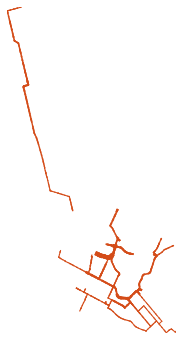

In [523]:
gplt.sankey(
    start=legwise_df.head(1000).apply(lambda srs: Point(srs.p1_long, srs.p1_lat), axis='columns'), 
    end=legwise_df.head(1000).apply(lambda srs: Point(srs.p2_long, srs.p2_lat), axis='columns'),
    scale=list(legwise_df.head(1000).n),
    projection=gcrs.AlbersEqualArea(),
    color='#d44c19'
)

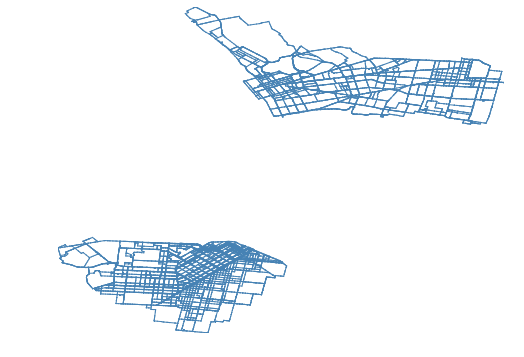

In [509]:
# warning -- this plot takes a long time to generate!
gplt.sankey(
    start=legwise_df.apply(lambda srs: Point(srs.p1_lat, srs.p1_long), axis='columns'), 
    end=legwise_df.apply(lambda srs: Point(srs.p2_lat, srs.p2_long), axis='columns'),
    scale=list(legwise_df.n)
)

We now have the dataset we need in exactly the right shape for the visualization work.